# Posterior Diagnostics: Residual, Time Delays & Ray Shooting

Three-panel diagnostic figure from a completed Alpaca pipeline run:
1. **Residual image** of the best-fit (MAP) model with reduced $\chi^2$
2. **Time-delay comparison**: measured vs modelled (posterior) for each image pair
3. **Ray-shooting scatter**: back-traced source positions from posterior samples

In [ ]:
import json
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

# Make alpaca importable
sys.path.insert(0, os.path.abspath(".."))

from alpaca.data.setup import setup_lens
from run_config import load_data

C_KM_S = 299792.458  # speed of light in km/s

## User Settings

In [21]:
# Path to a completed pipeline run directory
RUN_DIR = "../results/run_2026-01-27_17-02/"  # <-- EDIT THIS

In [22]:
# Data paths (same as used in the original run)
IMAGE_PATH     = "../data/image.fits"
PSF_PATH       = "../data/psf.fits"
NOISE_MAP_PATH = "../data/noise_map.fits"

In [23]:
# Measured (truth) time delays relative to image A, in days
# These are plotted as reference lines in the time-delay panel.
LABELS = ["A", "B", "C", "D"]  # A is the reference image
MEASURED_DELAYS = {  # label -> (delay_days, error_days)
    "B": (-11.645, 0.25),
    "C": (-9.403,  0.25),
    "D": (-2.139,  0.25),
}

In [24]:
# Number of posterior samples used for time-delay and ray-shooting panels
N_POSTERIOR_DRAWS = 300

## Load Data, Posterior & Best-Fit

In [25]:
# Load image data
img, psf_kernel, noise_map = load_data(IMAGE_PATH, PSF_PATH, NOISE_MAP_PATH)
print(f"Image shape: {img.shape}, PSF shape: {psf_kernel.shape}")

# If PSF reconstruction was run, use the final reconstructed PSF
psf_final_path = os.path.join(RUN_DIR, "psf_reconstruction", "fits", "psf_final.fits")
if os.path.exists(psf_final_path):
    from astropy.io import fits
    psf_kernel = np.asarray(fits.getdata(psf_final_path), dtype=float)
    print(f"Using reconstructed PSF from {psf_final_path}")

Image shape: (99, 99), PSF shape: (99, 99)


In [26]:
# Load posterior samples
post_path = os.path.join(RUN_DIR, "posterior", "posterior_samples.npz")
post_data = np.load(post_path, allow_pickle=True)
samples = post_data["samples"]
param_names = list(post_data["param_names"])
print(f"Posterior: {samples.shape[0]} samples, {samples.shape[1]} params")

# Load best-fit (MAP) parameters from multistart optimisation
bf_path = os.path.join(RUN_DIR, "multistart", "best_fit_params.json")
with open(bf_path) as f:
    best_fit = json.load(f)
print(f"Loaded MAP parameters from {bf_path}")

# Load pipeline config for setup_lens settings
cfg_path = os.path.join(RUN_DIR, "pipeline_config.json")
with open(cfg_path) as f:
    pipe_cfg = json.load(f)

Posterior: 5000 samples, 63 params
Loaded MAP parameters from ../results/run_2026-01-27_17-02/multistart/best_fit_params.json


## Recreate Model Setup

In [27]:
# Extract settings from pipeline config
corr_cfg = pipe_cfg.get("corr_field_config", {})

setup = setup_lens(
    img=img,
    psf_kernel=psf_kernel,
    noise_map=noise_map,
    use_source_shapelets=pipe_cfg.get("use_source_shapelets", True),
    shapelets_n_max=pipe_cfg.get("shapelets_n_max", 6),
    boost_noise_around_ps=pipe_cfg.get("boost_noise_around_ps", True),
    min_sep=pipe_cfg.get("ps_min_sep", 0.18),
    use_rayshoot_systematic_error=pipe_cfg.get("use_rayshoot_systematic_error", False),
    rayshoot_sys_error_min=pipe_cfg.get("rayshoot_sys_error_min", 0.00005),
    rayshoot_sys_error_max=pipe_cfg.get("rayshoot_sys_error_max", 0.005),
    use_corr_fields=pipe_cfg.get("use_corr_fields", False),
    corr_field_num_pixels=corr_cfg.get("num_pixels", 80),
    corr_field_mean_intensity=corr_cfg.get("mean_intensity"),
    corr_field_loglogavgslope=tuple(corr_cfg.get("loglogavgslope", (-6.0, 0.5))),
    corr_field_fluctuations=tuple(corr_cfg.get("fluctuations", (1.0, 0.5))),
    corr_field_cropped_border_size=corr_cfg.get("cropped_border_size", 20),
    arc_mask_inner_radius=corr_cfg.get("arc_mask_inner_radius", 0.3),
    arc_mask_outer_radius=corr_cfg.get("arc_mask_outer_radius", 2.5),
    custom_arc_mask_path=corr_cfg.get("custom_arc_mask_path"),
)

prob_model = setup["prob_model"]
lens_image = setup["lens_image"]
mass_model = lens_image.MassModel
n_images = len(setup["x0s"])
print(f"Setup complete: {n_images} point-source images detected")

Setup complete: 4 point-source images detected


## Helper Functions

In [28]:
def get_param_col(name):
    """Return the column index for a parameter name."""
    return param_names.index(name)


def sample_to_kwargs_lens(idx):
    """Build kwargs_lens from a single posterior sample row."""
    s = samples[idx]
    return [
        dict(
            theta_E=s[get_param_col("lens_theta_E")],
            e1=s[get_param_col("lens_e1")],
            e2=s[get_param_col("lens_e2")],
            center_x=s[get_param_col("lens_center_x")],
            center_y=s[get_param_col("lens_center_y")],
            gamma=s[get_param_col("lens_gamma")],
        ),
        dict(
            gamma1=s[get_param_col("lens_gamma1")],
            gamma2=s[get_param_col("lens_gamma2")],
            ra_0=0.0,
            dec_0=0.0,
        ),
    ]


def sample_to_image_pos(idx):
    """Return (ra, dec) arrays for point-source images from a sample."""
    s = samples[idx]
    ra = np.array([s[get_param_col(f"x_image_{i}")] for i in range(n_images)])
    dec = np.array([s[get_param_col(f"y_image_{i}")] for i in range(n_images)])
    return ra, dec

## Compute Diagnostics

In [29]:
# --- Panel 1: Residual from MAP ---
model_img = np.asarray(prob_model.model_image_from_params(best_fit))
residual = (img - model_img) / noise_map
chi2_red = prob_model.reduced_chi2(best_fit)
print(f"Reduced chi^2 = {chi2_red:.4f}")

Reduced chi^2 = 1.7305


In [30]:
# --- Panel 2: Time delays from posterior ---
rng = np.random.default_rng(42)
draw_idx = rng.choice(samples.shape[0], size=min(N_POSTERIOR_DRAWS, samples.shape[0]), replace=False)

has_Ddt = "D_dt" in param_names
if not has_Ddt:
    print("WARNING: D_dt not in posterior — time-delay panel will be empty.")

# Collect predicted delays for each pair (B-A, C-A, D-A)
n_pairs = n_images - 1
dt_pred_all = np.full((len(draw_idx), n_pairs), np.nan)

if has_Ddt:
    i_Ddt = get_param_col("D_dt")
    for k, idx in enumerate(draw_idx):
        kwargs_lens = sample_to_kwargs_lens(idx)
        ra, dec = sample_to_image_pos(idx)
        phi = np.asarray(mass_model.fermat_potential(ra, dec, kwargs_lens))
        delta_phi = phi[1:] - phi[0]
        D_dt = float(samples[idx, i_Ddt])
        dt_pred_all[k] = (C_KM_S / D_dt) * np.asarray(delta_phi)
    print(f"Computed predicted time delays for {len(draw_idx)} posterior samples")

Computed predicted time delays for 300 posterior samples


In [31]:
# --- Panel 3: Ray shooting scatter ---
x_src_all = np.full((len(draw_idx), n_images), np.nan)
y_src_all = np.full((len(draw_idx), n_images), np.nan)

for k, idx in enumerate(draw_idx):
    kwargs_lens = sample_to_kwargs_lens(idx)
    ra, dec = sample_to_image_pos(idx)
    xs, ys = mass_model.ray_shooting(ra, dec, kwargs_lens)
    x_src_all[k] = np.asarray(xs)
    y_src_all[k] = np.asarray(ys)

# Compute spread per sample (std of source positions)
spreads = np.sqrt(np.std(x_src_all, axis=1)**2 + np.std(y_src_all, axis=1)**2)
mean_spread_mas = np.mean(spreads) * 1000
median_spread_mas = np.median(spreads) * 1000
print(f"Ray-shooting spread: mean={mean_spread_mas:.2f} mas, median={median_spread_mas:.2f} mas")

Ray-shooting spread: mean=21.57 mas, median=21.57 mas


## Three-Panel Diagnostic Figure

Saved to ../results/run_2026-01-27_17-02/posterior_diagnostics.png


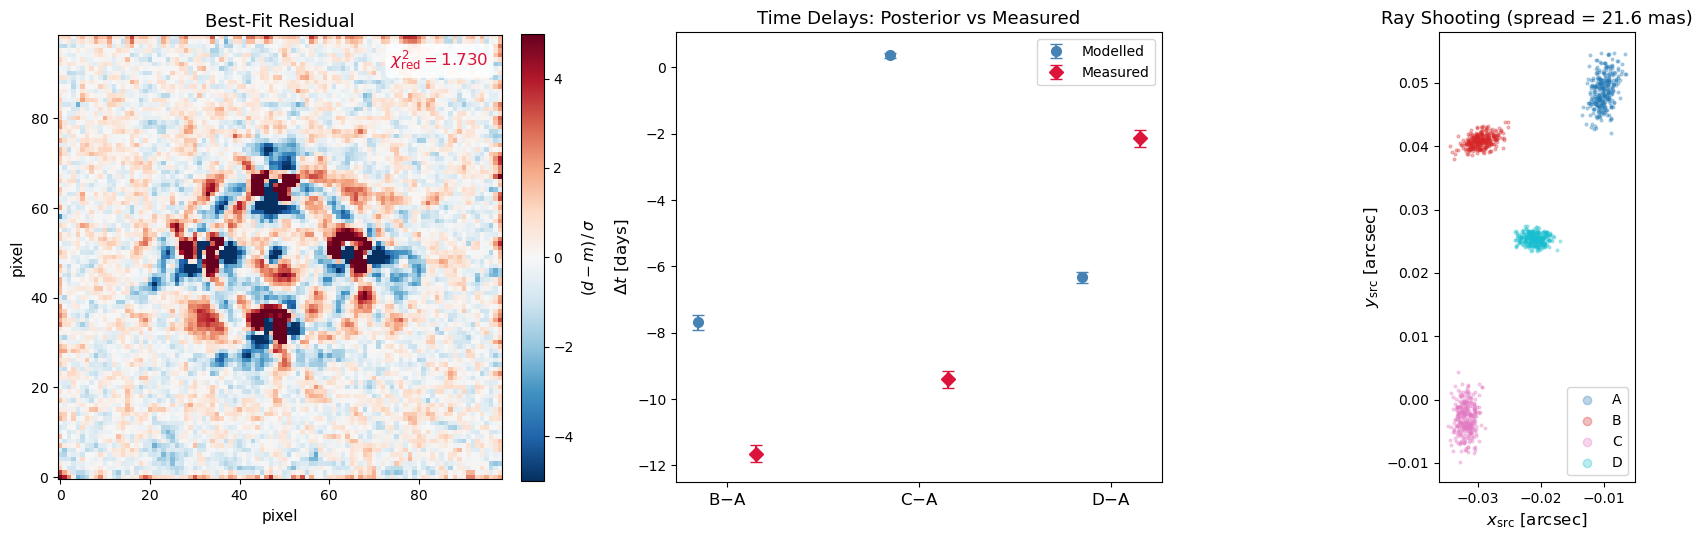

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5.5))

# =====================================================================
# Panel 1: Normalised residual
# =====================================================================
vmax = 5
im1 = ax1.imshow(residual, origin="lower", cmap="RdBu_r", vmin=-vmax, vmax=vmax)
cb1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
cb1.set_label(r"$(d - m) \,/\, \sigma$", fontsize=11)
ax1.set_title("Best-Fit Residual", fontsize=13)
ax1.text(
    0.97, 0.97,
    rf"$\chi^2_{{\rm red}} = {chi2_red:.3f}$",
    transform=ax1.transAxes, ha="right", va="top",
    fontsize=12, color="crimson",
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", boxstyle="round,pad=0.3"),
)
ax1.set_xlabel("pixel", fontsize=11)
ax1.set_ylabel("pixel", fontsize=11)

# =====================================================================
# Panel 2: Time delays — posterior vs measured
# =====================================================================
pair_labels = [f"{lab}$-$A" for lab in LABELS[1:]]
pair_x = np.arange(n_pairs)
offset = 0.15  # horizontal offset between modelled and measured points

if has_Ddt:
    # Posterior statistics
    dt_median = np.nanmedian(dt_pred_all, axis=0)
    dt_lo = np.nanpercentile(dt_pred_all, 16, axis=0)
    dt_hi = np.nanpercentile(dt_pred_all, 84, axis=0)

    # Modelled (posterior median +/- 1 sigma)
    ax2.errorbar(
        pair_x - offset, dt_median,
        yerr=[dt_median - dt_lo, dt_hi - dt_median],
        fmt="o", color="steelblue", ms=7, capsize=4, zorder=5,
        label="Modelled",
    )

    # Measured (truth) with error bars
    meas_vals = np.array([MEASURED_DELAYS[lab][0] for lab in LABELS[1:]])
    meas_errs = np.array([MEASURED_DELAYS[lab][1] for lab in LABELS[1:]])
    ax2.errorbar(
        pair_x + offset, meas_vals, yerr=meas_errs,
        fmt="D", color="crimson", ms=7, capsize=4, zorder=5,
        label="Measured",
    )
    ax2.legend(fontsize=10)
else:
    ax2.text(0.5, 0.5, "No D_dt in posterior\n(time delays not modelled)",
             ha="center", va="center", transform=ax2.transAxes, fontsize=12)

ax2.set_xticks(pair_x)
ax2.set_xticklabels(pair_labels, fontsize=12)
ax2.set_ylabel(r"$\Delta t$ [days]", fontsize=12)
ax2.set_title("Time Delays: Posterior vs Measured", fontsize=13)

# =====================================================================
# Panel 3: Ray-shooting scatter in source plane
# =====================================================================
colours = plt.cm.tab10(np.linspace(0, 1, n_images))
for j in range(n_images):
    ax3.scatter(
        x_src_all[:, j], y_src_all[:, j],
        s=4, alpha=0.3, color=colours[j], label=LABELS[j],
    )
ax3.set_xlabel(r"$x_{\rm src}$ [arcsec]", fontsize=12)
ax3.set_ylabel(r"$y_{\rm src}$ [arcsec]", fontsize=12)
ax3.set_title(f"Ray Shooting (spread = {median_spread_mas:.1f} mas)", fontsize=13)
ax3.legend(fontsize=10, markerscale=3)
ax3.set_aspect("equal")
ax3.ticklabel_format(useOffset=False)

plt.tight_layout()
save_path = os.path.join(RUN_DIR, "posterior_diagnostics.png")
plt.savefig(save_path, dpi=200, bbox_inches="tight")
print(f"Saved to {save_path}")
plt.show()